In [115]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib

In [117]:
# Limit GPU memory to 50%
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Assuming your GPU has 8GB memory, you set memory_limit to 4GB (50%).
    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 50% of 8GB GPU
    )

In [119]:
# Load data
X_train = np.load("../Model_train_data/X_train.npy", allow_pickle=True)
y_train = np.load("../Model_train_data/y_train.npy", allow_pickle=True)
X_test = np.load("../Model_train_data/X_test.npy", allow_pickle=True)
y_test = np.load("../Model_train_data/y_test.npy", allow_pickle=True)
yc_train = np.load("../Model_train_data/yc_train.npy", allow_pickle=True)
yc_test = np.load("../Model_train_data/yc_test.npy", allow_pickle=True)

In [121]:
# Define the generator
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,
                  #return_sequences=True,
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

In [123]:
# Define the discriminator
def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(ReLU())
    model.add(Dense(1))
    return model

In [125]:
# Train WGAN-GP model
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(3):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Showing loss every 15 epochs
            if (epoch + 1) % 15 == 0:
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)
            
        tf.keras.models.save_model(self.generator, '../Model/WGAN_model_final.h5')
        
        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('../Training_loss/WGAN_loss_plot.png')
        plt.show()

        print("REAL", Real_price.shape)
        print("PREDICTED", Predicted_price.shape)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

epoch 15 d_loss 9.352327 g_loss -0.023763685
epoch 30 d_loss 8.546562 g_loss -0.23973636
epoch 45 d_loss 6.9627547 g_loss 0.6762007
epoch 60 d_loss 6.7028766 g_loss 0.19032635
epoch 75 d_loss 5.3247743 g_loss 0.028911248
epoch 90 d_loss 3.4908526 g_loss 0.08835025


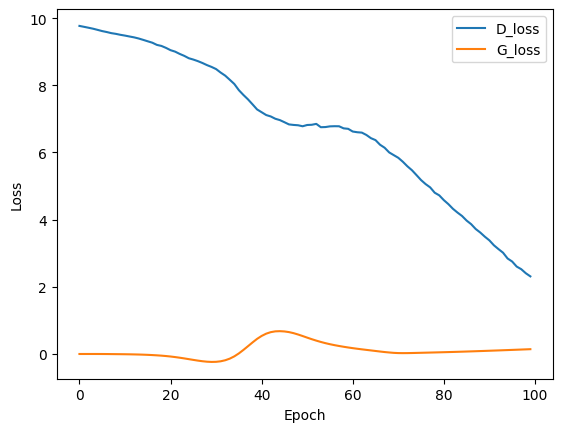

REAL (690, 1)
[[-3.79226502e-01]
 [-3.55557452e-01]
 [-3.66713611e-01]
 [-3.32541521e-01]
 [-3.32792890e-01]
 [-3.37064401e-01]
 [-3.51537089e-01]
 [-3.56612761e-01]
 [-3.42843466e-01]
 [-2.99676329e-01]
 [-3.48572256e-01]
 [-3.46612459e-01]
 [-3.47466673e-01]
 [-3.53597655e-01]
 [-3.58924255e-01]
 [-3.74100777e-01]
 [-4.09529051e-01]
 [-4.01136850e-01]
 [-4.38524922e-01]
 [-4.69480590e-01]
 [-4.95461354e-01]
 [-4.55259050e-01]
 [-4.32946732e-01]
 [-4.23298347e-01]
 [-4.47319093e-01]
 [-4.44303986e-01]
 [-4.28373798e-01]
 [-4.10885783e-01]
 [-4.06915915e-01]
 [-3.94151655e-01]
 [-4.02443308e-01]
 [-4.14805598e-01]
 [-3.76512818e-01]
 [-3.95307512e-01]
 [-4.36162934e-01]
 [-4.64857382e-01]
 [-4.89883385e-01]
 [-4.95511628e-01]
 [-5.52950578e-01]
 [-5.66820421e-01]
 [-5.37874824e-01]
 [-5.42397484e-01]
 [-5.70187224e-01]
 [-6.11847027e-01]
 [-7.69540367e-01]
 [-7.29237516e-01]
 [-8.21351074e-01]
 [-7.75821950e-01]
 [-8.67935507e-01]
 [-8.74317638e-01]
 [-9.14570215e-01]
 [-9.66581797e-01

In [127]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    epoch = 100

    generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = Discriminator()
    gan = GAN(generator, discriminator)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)

In [87]:
# Rescale back the real dataset
X_scaler = load(open('../Model_train_data/X_scaler.pkl', 'rb'))
y_scaler = load(open('../Model_train_data/y_scaler.pkl', 'rb'))
train_predict_index = np.load("../Model_train_data/index_train.npy", allow_pickle=True)
test_predict_index = np.load("../Model_train_data/index_test.npy", allow_pickle=True)

C:\Users\ASUS\anaconda3\envs\gpu_env\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [88]:
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

In [89]:
predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23888\1582397805.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23888\1582397805.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


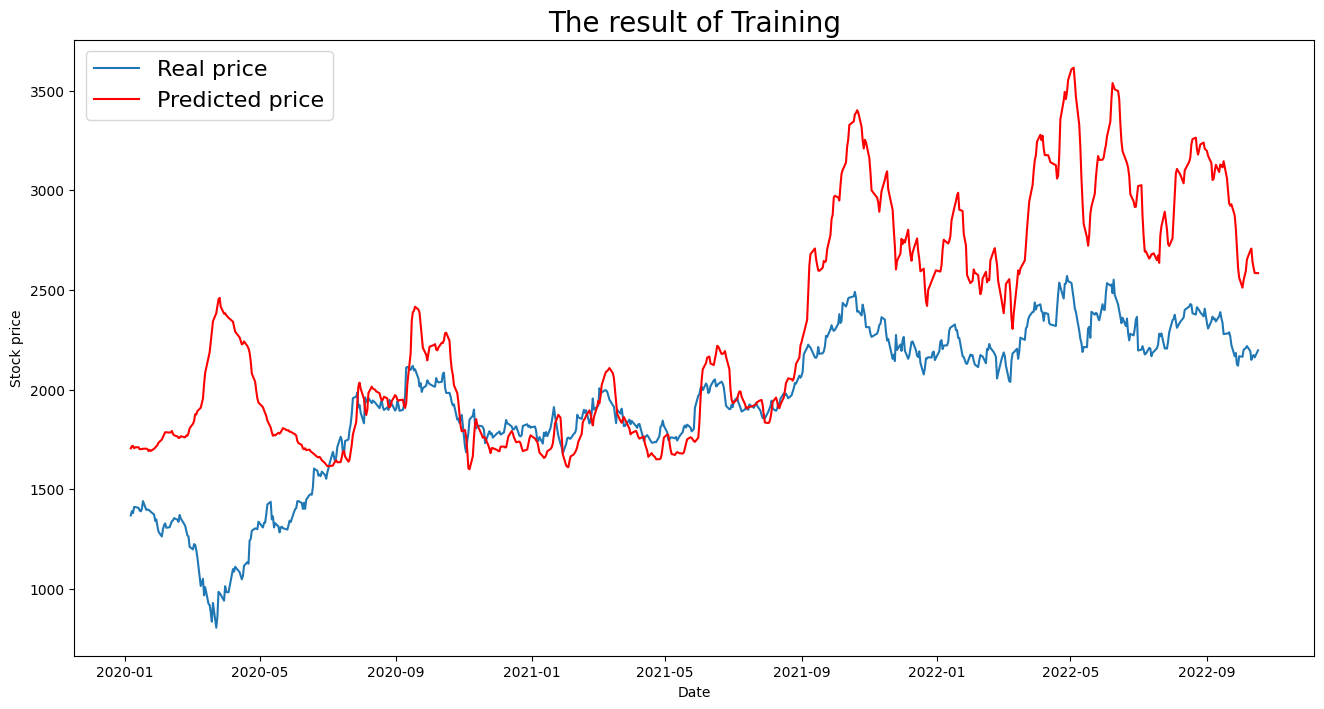

In [90]:
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.savefig('../Training_loss/WGAN_training_Stock_plot.png')
    plt.show()

In [91]:
# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

-- Train RMSE --  517.3789212513692


In [92]:
from tensorflow.keras.models import load_model
generator = load_model('../Model/WGAN_model_final.h5')

In [93]:
fake_test_scaled = generator.predict(X_test, batch_size=64)

In [94]:
# 4. Inverse‑scale the GAN’s outputs and the true test values
fake_test = y_scaler.inverse_transform(
    fake_test_scaled.reshape(-1, 1)
).reshape(fake_test_scaled.shape)

In [95]:
real_test = y_scaler.inverse_transform(
    y_test.reshape(-1, 1)
).reshape(y_test.shape)

In [96]:
predict_result = pd.DataFrame()
for i in range(fake_test.shape[0]):
    y_predict = pd.DataFrame(fake_test[i], columns=["predicted_price"], index=test_predict_index[i:i+y_test.shape[1]])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(real_test.shape[0]):
    y_train = pd.DataFrame(real_test[i], columns=["real_price"], index=test_predict_index[i:i+y_test.shape[1]])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23888\4138306018.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23888\4138306018.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


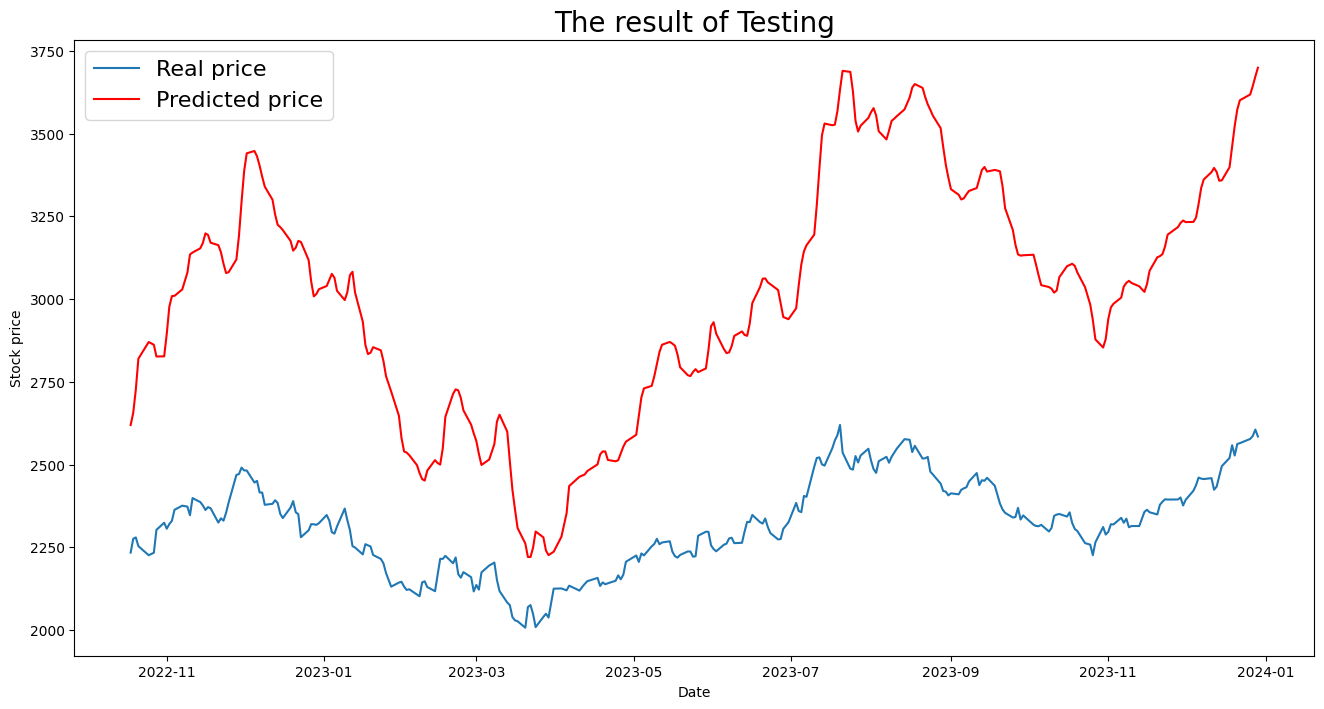

-- Test RMSE --  735.9876618015992


In [97]:
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.savefig('../Training_loss/WGAN_Testing_plot.png')
    plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Test RMSE -- ', RMSE)